# Plot vertical profiles of VISION output

In [1]:
# IMPORT LIBRARIES
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator, LongitudeLocator)
import os
import cf
import numpy as np
import numpy.ma as ma
from datetime import datetime

#################################
# Colours for line plots, light to dark
greens=['#a6dba0','#5aae61','#1b7837','#00441b'] 
purples=['#c2a5cf', '#9970ab', '#762a83', '#40004b']
greys=['#bababa','#878787','#4d4d4d','#1a1a1a']
blues= ['#9ecae1','#6baed6','#2171b5','#084594'] 
#################################

In [2]:
# SELECT OPTIONS HERE
outdir='/home/vagrant/Plots/'
select_species='O3'
# Select specific start/end year for the analysis (if required)
l_subset_time=False ; start_t='2015-01-01' ; end_t='2020-12-31'
# Select latitudes and altitudes for the analysis (if required).
l_subset_lats= True ; selected_lats= [-30,30]
l_errorbars=True
# band_size, xplot, yplot

In [3]:
# READ AND PROCESS DATA

# Define variables for FAAM data
source1='FAAM'
sourcedir1='/home/vagrant/Tutorials/UMvn13.9/data/Task16/FAAM_ozone_cf_compliant_2010_2020/'
#slabel1='FAAM O3 '
vunits1=' (ppbv)'
vfactor1=1.
vmin1=3. # removes negative values and very low values collected during taxiing

# Define variables for UKCA data
source2='UKCA'
sourcedir2='/home/vagrant/Tutorials/UMvn13.9/data/Task16/UKCA_ozone_cf_compliant_2010_2020/'
#slabel2='UKCA O3 '
vunits2=' (ppbv)'
vmin2=None
vfactor2=1.e9/1.657 # converts UKCA data (kg/kg) to ppbv 

# Create plot title and filename for output
plot_title = "Ozone profile"
outfile=outdir+"vertical_profile_"+source1+'_'+source2

# Read and concatenate data
rdata1=cf.read(sourcedir1+'*.nc')
rdata1=rdata1.concatenate()
rdata2=cf.read(sourcedir2+'*.nc')
rdata2=rdata2.concatenate()

# Extract data for selected times
if l_subset_time:
    rdata1 = rdata1.subspace(T=cf.wi(cf.dt(start_t), cf.dt(end_t)))
    rdata2 = rdata2.subspace(T=cf.wi(cf.dt(start_t), cf.dt(end_t)))
    time_spec=str(start_t[0:4])+'_'+str(end_t[0:4])
    plot_title=plot_title+' ('+str(start_t[0:5])+str(end_t[0:4])+')'
    outfile=outfile+'_'+time_spec

# Extract data for selected latitudes
if l_subset_lats:
    rdata1 = rdata1.subspace(latitude=cf.wi(selected_lats[0], selected_lats[1]))
    rdata2 = rdata2.subspace(latitude=cf.wi(selected_lats[0], selected_lats[1]))
    lat_spec=str(selected_lats[0])+':'+str(selected_lats[1])
    plot_title=plot_title + ' [lats='+ lat_spec+']'
    outfile1=outfile+'_'+lat_spec

# Apply conversion factors
rdata1.data=rdata1.data * vfactor1
rdata2.data=rdata2.data * vfactor2

# Remove values below a set minimum
if vmin1 is not None:
    rdata1=rdata1.where(rdata1.array <= vmin1, cf.masked)
if vmin2 is not None:
    rdata2=rdata2.where(rdata2.array <= vmin2, cf.masked)

# Remove nan    
rdata1.data=rdata1.data.filled(np.nan)
nan_mask = np.isnan(rdata1.array.data)
rdata1=rdata1.where(nan_mask, cf.masked)

rdata2.data=rdata2.data.filled(np.nan)
nan_mask = np.isnan(rdata2.array.data)
rdata2=rdata2.where(nan_mask, cf.masked)

In [4]:
# Create mean vertical profiles
max_altitude=11
band_size = 1
n_lev=round(max_altitude/band_size)

# Define model and obs vertically varying lists
pz1=[None]* n_lev ; vp1=[None]*n_lev ; q25_1=[None]*n_lev ; q75_1=[None]*n_lev
pz2=[None]* n_lev ; vp2=[None]*n_lev ; q25_2=[None]*n_lev ; q75_2=[None]*n_lev
for z in range(n_lev):
    lower=z*band_size*1000
    upper=(z+1)*band_size*1000
    # select obs and model data within vertical band for averaging
    alt1=rdata1.coordinate('altitude').array
    select_alt1 = (alt1 >= lower) & (alt1 <= upper)
    alt2=rdata2.coordinate('altitude').array
    select_alt2 = (alt2 >= lower) & (alt2 <= upper)
    
    # Extract vertical profile for observations 
    if select_alt1.any():
        # make sure there are data points within the band
        npoints=select_alt1.sum()
        pz1[z]=(z*band_size + (z+1)*band_size)/2.
        rdata_band=rdata1.subspace(altitude=cf.wi(lower,upper)).array
        vp1[z]=np.ma.mean(rdata_band)
        q25, q75 = np.percentile(rdata_band.compressed(), [25, 75])
        q25_1[z]=q25
        q75_1[z]=q75
    # Extract vertical profile for the model
    if select_alt2.any():
        # make sure there are data points within the band
        npoints=select_alt2.sum()
        pz2[z]=(z*band_size + (z+1)*band_size)/2.
        rdata_band=rdata2.subspace(altitude=cf.wi(lower,upper)).array
        vp2[z]=np.ma.mean(rdata_band)
        q25, q75 = np.percentile(rdata_band.compressed(), [25, 75])
        q25_2[z]=q25
        q75_2[z]=q75

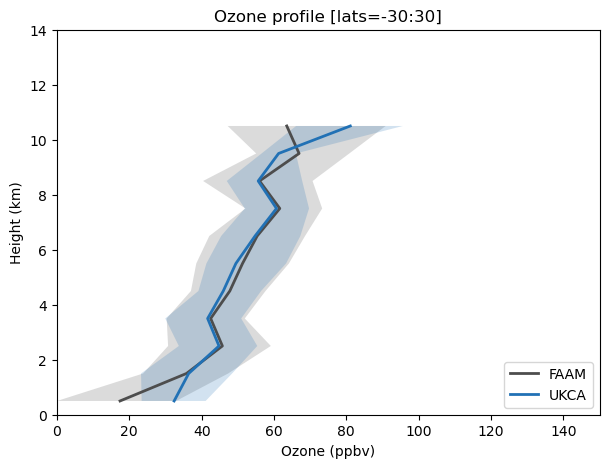

In [5]:
# PLOT OZONE VERTICAL PROFILE

# Define figure and size
fig = plt.figure(figsize=(7, 5))

ax1=fig.add_subplot(1, 1, 1)

# Add error bars if required: these are defined by the inter quartile range (25th to 75th percentiles)
if l_errorbars:
    ax1.fill_betweenx(pz1,q25_1,q75_1,alpha=0.2, color=greys[2], edgecolor=None)
    ax1.fill_betweenx(pz2,q25_2,q75_2,alpha=0.2, color=blues[2], edgecolor=None)

ax1.plot(vp1,pz1, '-', color=greys[2],linewidth=2.0,label=source1)
ax1.plot(vp2,pz2, '-', color=blues[2],linewidth=2.0,label=source2)

ax1.set_xlim(0,150)
ax1.set_ylim(0,14)
# 
ax1.legend(loc="lower right", title="")
ax1.set_title(plot_title)
ax1.set_xlabel('Ozone (ppbv)')
ax1.set_ylabel('Height (km)')


plt.savefig(outdir+source1+'_'+source2+'_vertical_profile.png',dpi=300,bbox_inches='tight')
